In [1]:
# Date: 28/05/2021
# Author: Joshua Soutelo Vieira

In [1]:
import os
import json

import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
DATA_FOLDER = "data"
OUTPUT_FOLDER = "output"

In [2]:
def show_image(image, name=None):
    plt.title(name)
    plt.xlabel(str(image.shape[1]) + " px")
    plt.ylabel(str(image.shape[0]) + " px")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
def grab_fields_coords(file):
    with open(file, "r") as f:
        content = json.loads(f.read())

    return content    

In [4]:
# Gray scale image + Tresholding => B&W image
def bw(image, threshold=None, show=False):
    # First transform the image to gray scale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Sometimes we choose to set the threshold manually assuming that the Otsu algorithm wasn't unable to find a proper one
    if threshold:
        (thresh, bw_img) = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY_INV)
    else:
        # Treshold set to -0 to point out that it's Otsu's algorithm job to decide it
        (thresh, bw_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    if show:
        show_image(gray_img, "Gray scale")
        show_image(bw_img, "Trehshold (B&W)")
    
    return bw_img

In [5]:
# Gaussian Blur
def gauss_blur(image, show=False):
    
    gauss_img = cv2.GaussianBlur(
        src=image,
        ksize=(3,3),
        sigmaX=.5)
    
    if show: show_image(gauss_img, "Gaussian Blur")
    
    return gauss_img

In [6]:
"""
 It coalesces rectangles until we end up with the outmost rectangle. It only takes into account rectangles that
 are at least 
"""
# ROI Extraction
def roi(bw_img, gauss_img, rect_thresh=3, show=False):
    
    ctrs, hier = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    if len(rects) == 1: # Only one contour found
        x, y, w, h = rects[0]
    
    else:
        # This approach coalesces rectangles in a way that we end up with the outmost ROI
        x, y, w, h = (None, None, None, None)
        for r in rects:
            # Unpack elements
            x1, y1, w1, h1 = r
            # If the width or height of the rectangle passes a threshold value
            if w1 >= rect_thresh and h1 >= rect_thresh:
                if x != None and y != None and w != None and h != None:
                    # We have to take that x or y that is closer to the origin
                    if x1 < x:
                        x_tmp = x1
                    else:
                        x_tmp = x
                    if y1 < y:
                        y_tmp = y1
                    else:
                        y_tmp = y
                    # We have to compute the new width and height with respect of the outer x and y
                    if x1 + w1 > x + w:
                        w_tmp = (x1 + w1) - x_tmp
                    else:
                        w_tmp = (x + w) - x_tmp
                    if y1 + h1 > y + h:
                        h_tmp = (y1 + h1) - y_tmp
                    else:
                        h_tmp = (y + h) - y_tmp
                    # Update the outmost ROI
                    x, y, w, h = x_tmp, y_tmp, w_tmp, h_tmp
                else:
                    x, y, w, h = r
        # We didn't find a proper rectangle. Assing the one with smallest width or height so we assure that 
        # the thresholding algorithm will run again with a manual value
        if x == None and y == None and w == None and h == None:
            x, y, w, h = rects[0]
            for r in rects[1:]:
                x1, y1, w1, h1 = r
                if w1 < w or h1 < h:
                    x, y, w, h = r
    """
    for r in rects:
        x1, y1, w1, h1 = r
        show_image(gauss_img[y1:y1+h1, x1:x1+w1])
    """
    
    roi = gauss_img[y:y+h, x:x+w]
    
    if show: show_image(roi, "ROI")
    
    return roi

In [7]:
def pad_resize(roi_img, show=False):    
    # Extracted ROI centered in a square frame with lengths equal to the largest dimension
    h, w = roi_img.shape
    l_dim = max(h, w)
    bg_img = np.zeros((l_dim, l_dim)).astype('uint8')
    
    # Compute xoff and yoff for placement of upper left corner of resized image
    yoff = round((l_dim-h)/2)
    xoff = round((l_dim-w)/2)

    cent_img = bg_img.copy()
    cent_img[yoff:yoff+h, xoff:xoff+w] = roi_img
    if show: show_image(cent_img, "Centered")

    # Square frame padded with two empty pixels
    pad_img = cv2.copyMakeBorder(cent_img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
    if show: show_image(pad_img, "Padded")

    # Downscale or upscale https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/
    #res_img = cv2.resize(src=pad_img, dsize=(28,28), fx=1, fy=1, interpolation=cv2.INTER_CUBIC)
    res_img = cv2.resize(src=pad_img, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
    if show: show_image(res_img, "Resized Image")
    
    return res_img

WRITEUP NO. 120 60 141 29


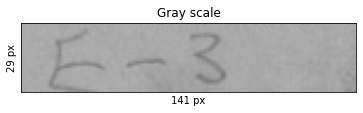

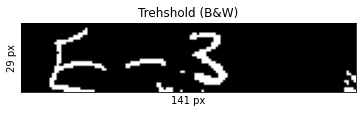

[(76, 28, 1, 1), (67, 28, 1, 1), (136, 27, 5, 2), (57, 25, 7, 4), (136, 24, 2, 2), (137, 20, 4, 5), (67, 20, 2, 1), (44, 15, 17, 4), (71, 4, 16, 22), (12, 2, 24, 27)]


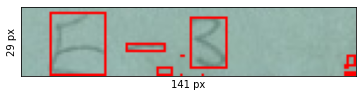

PHOTO NO. 968 68 136 28


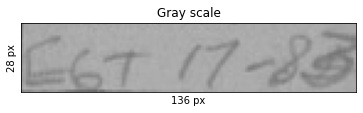

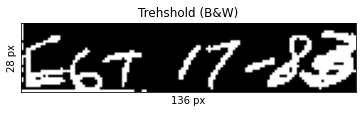

[(49, 27, 2, 1), (0, 22, 1, 2), (0, 18, 1, 2), (91, 14, 12, 6), (33, 11, 16, 15), (64, 9, 9, 14), (0, 8, 1, 3), (75, 7, 14, 20), (100, 5, 18, 21), (0, 5, 46, 23), (113, 3, 23, 24), (0, 0, 1, 7)]


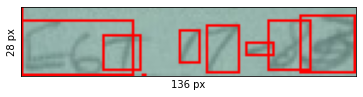

FOREST 120 109 195 27


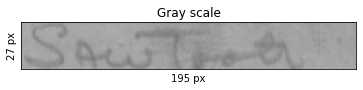

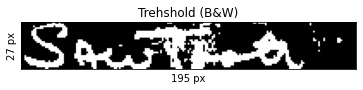

[(95, 21, 2, 2), (173, 16, 1, 1), (81, 16, 1, 2), (97, 15, 2, 3), (57, 13, 2, 1), (97, 12, 1, 1), (173, 11, 1, 3), (31, 10, 49, 17), (184, 9, 3, 3), (176, 9, 1, 2), (170, 9, 2, 2), (115, 6, 1, 1), (170, 5, 1, 1), (113, 1, 3, 2), (100, 1, 1, 1), (168, 0, 1, 2), (138, 0, 5, 2), (135, 0, 2, 1), (66, 0, 99, 27), (85, 0, 3, 1), (2, 0, 25, 27)]


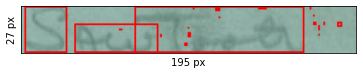

RANGER DISTRICT 319 109 231 31


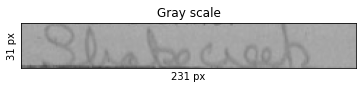

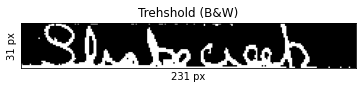

[(226, 30, 1, 1), (220, 30, 1, 1), (212, 30, 1, 1), (12, 10, 1, 1), (144, 0, 2, 2), (132, 0, 6, 2), (126, 0, 1, 2), (119, 0, 1, 1), (114, 0, 1, 1), (106, 0, 2, 1), (99, 0, 1, 1), (95, 0, 3, 1), (88, 0, 1, 1), (79, 0, 1, 1), (76, 0, 2, 1), (48, 0, 5, 1), (39, 0, 1, 1), (37, 0, 1, 1), (0, 0, 204, 31)]


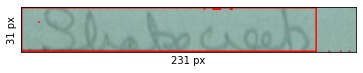

ALLOTMENT 555 113 266 27


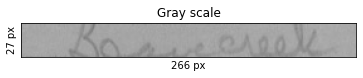

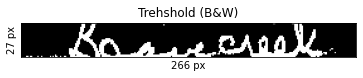

[(34, 26, 2, 1), (31, 26, 1, 1), (25, 26, 1, 1), (23, 26, 1, 1), (16, 26, 1, 1), (13, 26, 1, 1), (7, 26, 2, 1), (4, 26, 2, 1), (27, 25, 2, 2), (249, 23, 1, 1), (245, 20, 3, 2), (113, 1, 1, 1), (156, 0, 87, 27), (200, 0, 2, 1), (38, 0, 117, 27)]


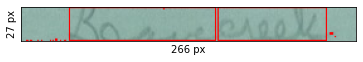

EXAMINER 825 115 173 27


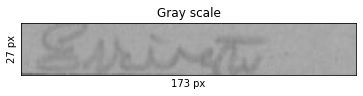

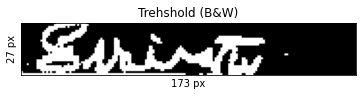

[(92, 26, 2, 1), (3, 21, 1, 1), (136, 16, 2, 1), (67, 6, 6, 5), (0, 0, 126, 27)]


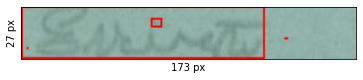

DATE 1002 116 102 27


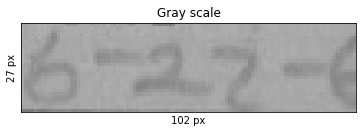

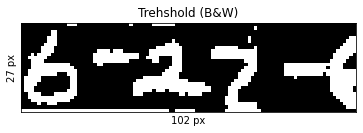

[(47, 26, 6, 1), (0, 26, 45, 1), (22, 8, 14, 5), (58, 7, 15, 20), (34, 5, 24, 17), (80, 4, 22, 22), (69, 4, 1, 2), (1, 2, 16, 23), (71, 1, 1, 1), (40, 0, 7, 1), (33, 0, 1, 1), (14, 0, 3, 1)]


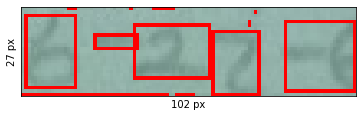

TRANSECT NO. 119 157 149 28


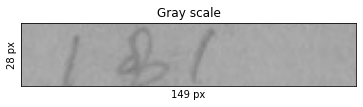

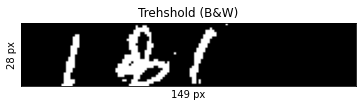

[(79, 25, 1, 2), (45, 25, 2, 1), (68, 13, 1, 1), (18, 5, 8, 23), (75, 2, 12, 25), (42, 1, 24, 27), (91, 0, 1, 1)]


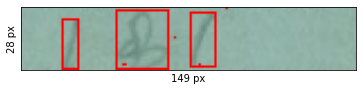

PLOT SIZE 275 160 93 26


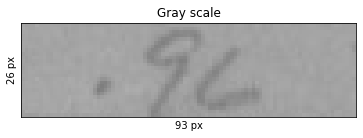

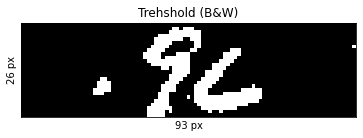

[(46, 20, 1, 1), (20, 15, 5, 5), (48, 7, 19, 18), (92, 6, 1, 1), (34, 1, 16, 25)]


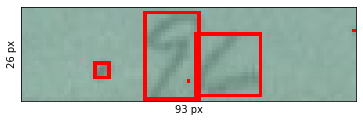

PLOT INTERVAL 375 160 174 29


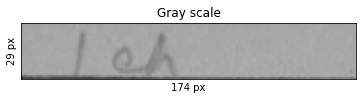

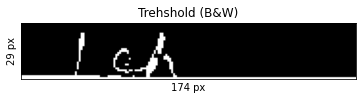

[(54, 21, 2, 1), (56, 18, 1, 1), (48, 13, 10, 13), (0, 5, 174, 24), (29, 5, 4, 19)]


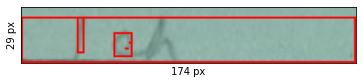

TYPE DESIGNATION 555 160 193 28


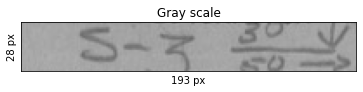

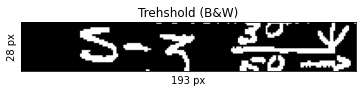

[(72, 27, 2, 1), (126, 22, 11, 6), (132, 20, 9, 4), (161, 19, 29, 9), (142, 19, 10, 9), (59, 12, 16, 5), (80, 7, 20, 21), (34, 3, 22, 20), (192, 0, 1, 1), (121, 0, 68, 18), (165, 0, 1, 1), (158, 0, 2, 1), (141, 0, 15, 9), (125, 0, 13, 13), (123, 0, 1, 1), (119, 0, 1, 1), (113, 0, 1, 1), (105, 0, 4, 1), (98, 0, 2, 1), (87, 0, 3, 1), (78, 0, 3, 1)]


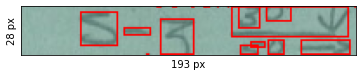

KIND OF LIVESTOCK 752 162 172 28


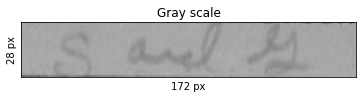

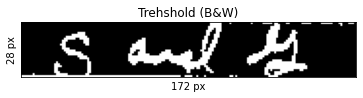

[(110, 27, 1, 1), (107, 27, 2, 1), (94, 27, 1, 1), (90, 27, 1, 1), (84, 27, 4, 1), (0, 5, 82, 23), (168, 0, 3, 1), (163, 0, 2, 2), (154, 0, 6, 1), (144, 0, 5, 1), (136, 0, 2, 1), (116, 0, 31, 28), (124, 0, 5, 1), (118, 0, 1, 1), (107, 0, 1, 1), (55, 0, 48, 26)]


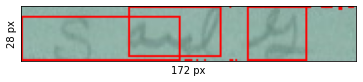

SLOPE 928 164 69 25


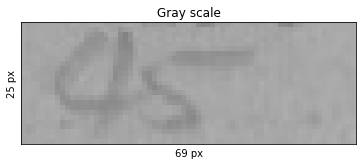

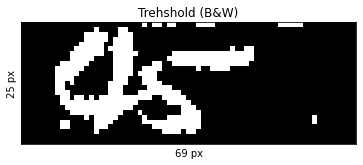

[(8, 20, 2, 2), (60, 19, 1, 2), (30, 5, 18, 5), (7, 1, 30, 22), (53, 0, 5, 1), (36, 0, 4, 1), (30, 0, 2, 1), (27, 0, 2, 1), (25, 0, 1, 1)]


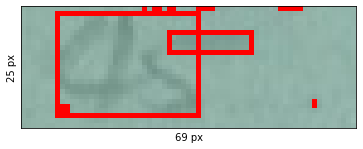

ASPECT 1003 167 100 24


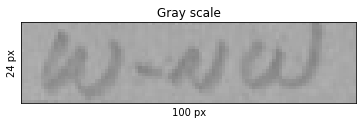

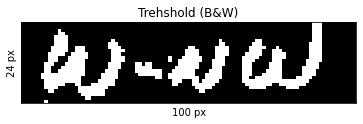

[(7, 23, 1, 1), (34, 12, 8, 5), (44, 10, 1, 2), (44, 5, 18, 16), (6, 2, 25, 21), (66, 0, 24, 20)]


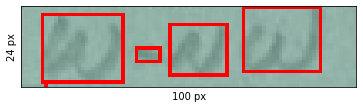

LOCATION 120 206 876 34


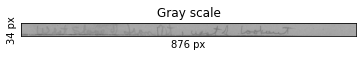

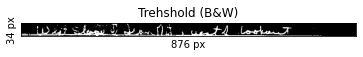

[(782, 33, 3, 1), (774, 33, 6, 1), (764, 33, 9, 1), (213, 33, 1, 1), (179, 33, 2, 1), (170, 33, 1, 1), (154, 33, 1, 1), (137, 33, 1, 1), (130, 33, 2, 1), (107, 33, 1, 1), (97, 33, 6, 1), (0, 33, 19, 1), (693, 31, 1, 1), (0, 28, 19, 3), (568, 26, 2, 2), (298, 26, 1, 1), (319, 25, 3, 2), (388, 24, 2, 2), (150, 21, 1, 3), (483, 20, 1, 1), (87, 18, 1, 1), (234, 16, 10, 10), (109, 15, 2, 1), (765, 14, 1, 1), (87, 14, 3, 2), (112, 13, 8, 8), (104, 13, 3, 2), (135, 12, 13, 10), (393, 11, 1, 2), (382, 10, 11, 11), (206, 10, 1, 1), (141, 10, 9, 3), (114, 10, 1, 1), (196, 9, 1, 2), (42, 8, 3, 7), (575, 7, 133, 24), (279, 6, 4, 8), (213, 6, 3, 2), (234, 5, 1, 1), (223, 5, 2, 2), (205, 5, 3, 4), (115, 5, 2, 3), (95, 5, 1, 2), (387, 4, 2, 3), (227, 4, 1, 1), (199, 4, 3, 3), (21, 4, 741, 30), (194, 2, 1, 1), (277, 0, 4, 5), (237, 0, 16, 15)]


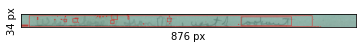

ELEVATION 1002 214 101 26


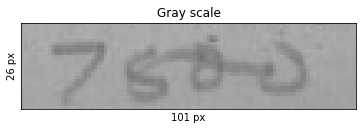

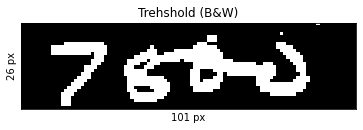

[(9, 6, 17, 19), (31, 4, 56, 20), (78, 3, 1, 1), (89, 0, 1, 1)]


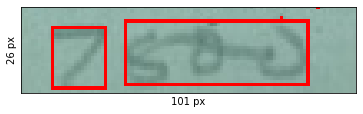

In [41]:
fields = grab_fields_coords("all_fields.json")['fields']
form = cv2.imread("highRes_ForestService.jpg")
i = 1
for field in fields:
    name = field['field']
    x = field['coord_pixel'][0]
    y = field['coord_pixel'][1]
    w = field['width']
    h = field['height']
    print(name, x, y, w, h)
    
    form_field = form[y:y+h, x:x+w]
    cv2.imwrite(f"/home/jsv/Documents/ForestProject/test/char_detection/output/field_{i}.jpg", form_field)
    i += 1
    
    bw_img = bw(form_field, show=True)
    
    # ROI
    
    ctrs, hier = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    form_field_copy = form_field.copy()
    print(rects)
    for rect in rects:
        
        rx, ry, rw, rh = rect
        form_field_copy = cv2.rectangle(form_field_copy, rect, (0, 0, 255), 1)
    show_image(form_field_copy)
    
    


## Second approach.
https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/
https://medium.com/swlh/pytorch-real-step-by-step-implementation-of-cnn-on-mnist-304b7140605a (If the restriction pops up, just open it from incoginito mode...)

The main idea here is:
> Step #1: Input an image. <br>
Step #2: Construct an image pyramid <br>
Step #3: For each scale of the image pyramid, run a sliding window <br>
Step #3a: For each stop of the sliding window, extract the ROI <br>
Step #3b: Take the ROI and pass it through our CNN originally trained for image classification <br>
Step #3c: Examine the probability of the top class label of the CNN, and if meets a minimum confidence, record (1) the class label and (2) the location of the sliding window <br>
Step #4: Apply class-wise non-maxima suppression to the bounding boxes <br>
Step #5: Return results to calling function <br>

In order to achieve all this steps, we need to train a CNN that performs good at the character classification task. (steps #3b and #3c)

### Step 1. Input an image

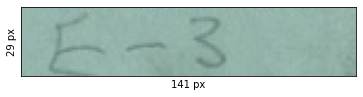

In [31]:
fields = grab_fields_coords("all_fields.json")['fields']
form = cv2.imread("highRes_ForestService.jpg")

def grab_fields():
    toret = {}
    
    for field in fields:
        name = field['field']
        x = field['coord_pixel'][0]
        y = field['coord_pixel'][1]
        w = field['width']
        h = field['height']
    
        form_field = form[y:y+h, x:x+w]
        toret[name] = form_field
    
    return toret
        
fields = grab_fields()
field = fields[list(fields)[0]]
show_image(field)

### Step 2. Construct image pyramid

*Should we upscale, downscale or both?*

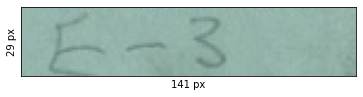

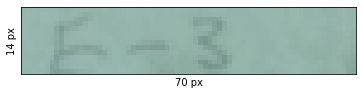

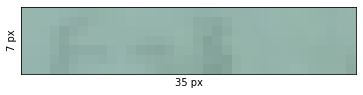

In [106]:
def image_pyramid_downscale(image, scale=2, minSize=10):
    toret = []
    toret.append(image)
    h, w, _ = map(int, image.shape)
    while h >= minSize and w >= minSize:
        image = cv2.pyrDown(image, dstsize=(w // scale, h // scale))
        h, w, _ = map(int, image.shape)
        toret.append(image)
    return toret
        

pyramids = image_pyramid_downscale(field)
for pyramid in pyramids:
    show_image(pyramid)

### Step 3: For each scale of the image pyramid, run a sliding window

{'x': 0, 'y': 0, 'h': 29, 'w': 20}


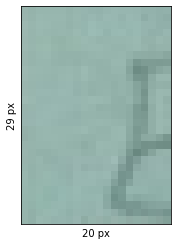

{'x': 2, 'y': 0, 'h': 29, 'w': 20}


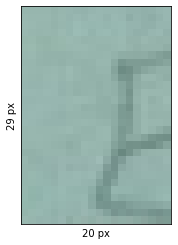

{'x': 4, 'y': 0, 'h': 29, 'w': 20}


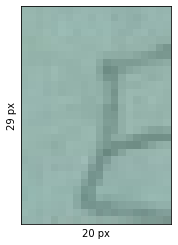

{'x': 6, 'y': 0, 'h': 29, 'w': 20}


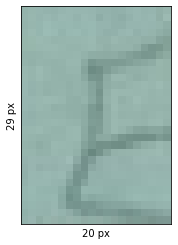

{'x': 8, 'y': 0, 'h': 29, 'w': 20}


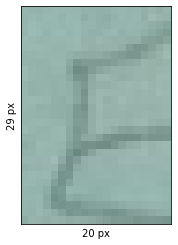

{'x': 10, 'y': 0, 'h': 29, 'w': 20}


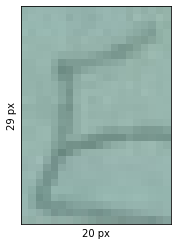

{'x': 12, 'y': 0, 'h': 29, 'w': 20}


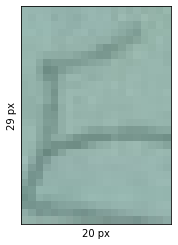

{'x': 14, 'y': 0, 'h': 29, 'w': 20}


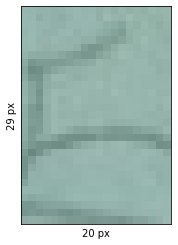

{'x': 16, 'y': 0, 'h': 29, 'w': 20}


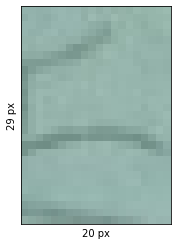

{'x': 18, 'y': 0, 'h': 29, 'w': 20}


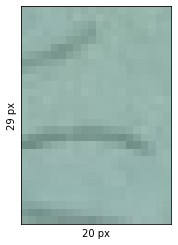

{'x': 20, 'y': 0, 'h': 29, 'w': 20}


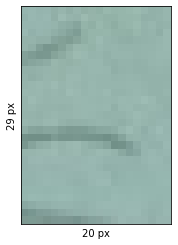

{'x': 22, 'y': 0, 'h': 29, 'w': 20}


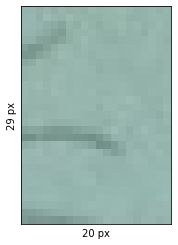

{'x': 24, 'y': 0, 'h': 29, 'w': 20}


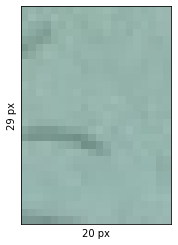

{'x': 26, 'y': 0, 'h': 29, 'w': 20}


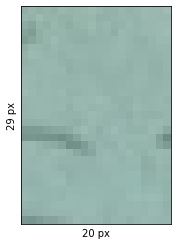

{'x': 28, 'y': 0, 'h': 29, 'w': 20}


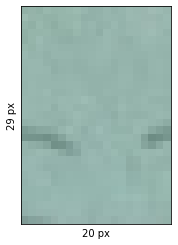

{'x': 30, 'y': 0, 'h': 29, 'w': 20}


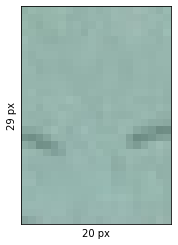

{'x': 32, 'y': 0, 'h': 29, 'w': 20}


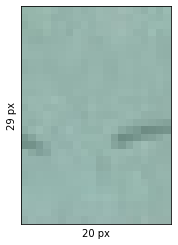

{'x': 34, 'y': 0, 'h': 29, 'w': 20}


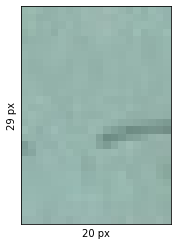

{'x': 36, 'y': 0, 'h': 29, 'w': 20}


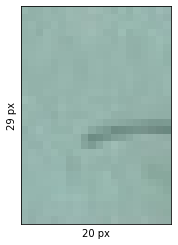

{'x': 38, 'y': 0, 'h': 29, 'w': 20}


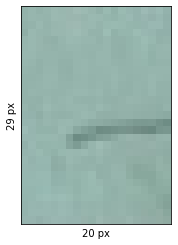

{'x': 40, 'y': 0, 'h': 29, 'w': 20}


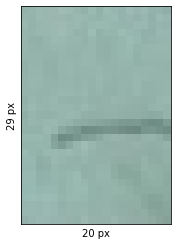

{'x': 42, 'y': 0, 'h': 29, 'w': 20}


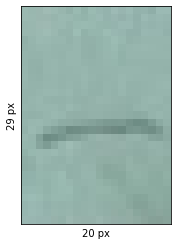

{'x': 44, 'y': 0, 'h': 29, 'w': 20}


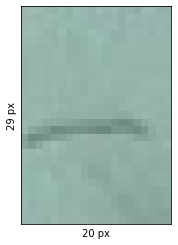

{'x': 46, 'y': 0, 'h': 29, 'w': 20}


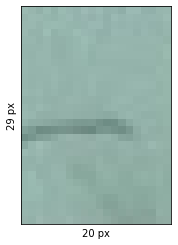

{'x': 48, 'y': 0, 'h': 29, 'w': 20}


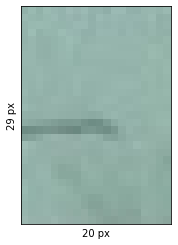

{'x': 50, 'y': 0, 'h': 29, 'w': 20}


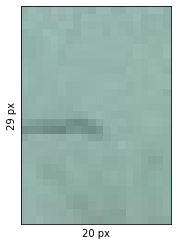

{'x': 52, 'y': 0, 'h': 29, 'w': 20}


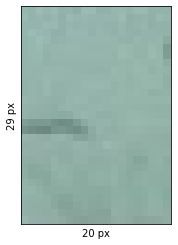

{'x': 54, 'y': 0, 'h': 29, 'w': 20}


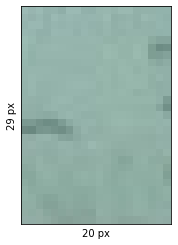

{'x': 56, 'y': 0, 'h': 29, 'w': 20}


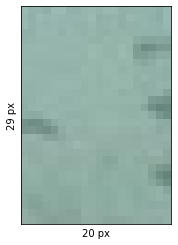

{'x': 58, 'y': 0, 'h': 29, 'w': 20}


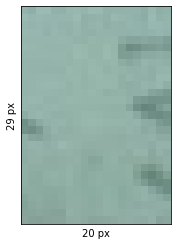

{'x': 60, 'y': 0, 'h': 29, 'w': 20}


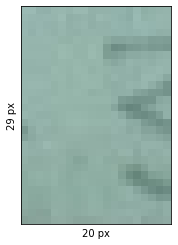

{'x': 62, 'y': 0, 'h': 29, 'w': 20}


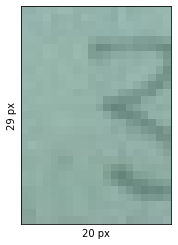

{'x': 64, 'y': 0, 'h': 29, 'w': 20}


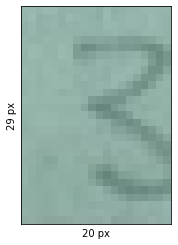

{'x': 66, 'y': 0, 'h': 29, 'w': 20}


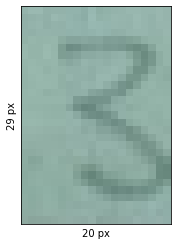

{'x': 68, 'y': 0, 'h': 29, 'w': 20}


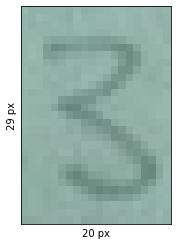

{'x': 70, 'y': 0, 'h': 29, 'w': 20}


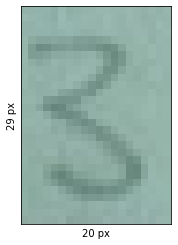

{'x': 72, 'y': 0, 'h': 29, 'w': 20}


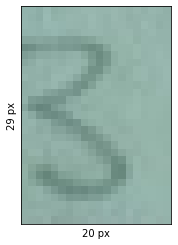

{'x': 74, 'y': 0, 'h': 29, 'w': 20}


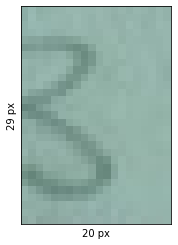

{'x': 76, 'y': 0, 'h': 29, 'w': 20}


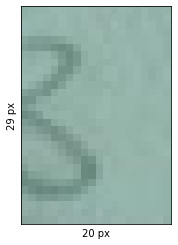

{'x': 78, 'y': 0, 'h': 29, 'w': 20}


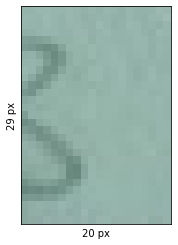

{'x': 80, 'y': 0, 'h': 29, 'w': 20}


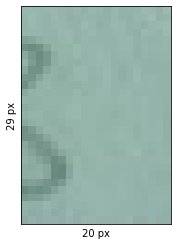

{'x': 82, 'y': 0, 'h': 29, 'w': 20}


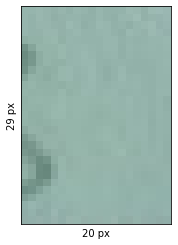

{'x': 84, 'y': 0, 'h': 29, 'w': 20}


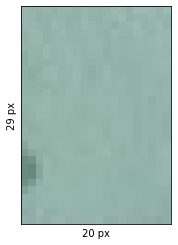

{'x': 86, 'y': 0, 'h': 29, 'w': 20}


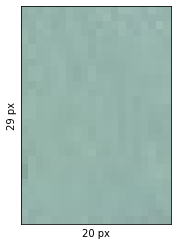

{'x': 88, 'y': 0, 'h': 29, 'w': 20}


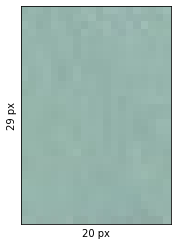

{'x': 90, 'y': 0, 'h': 29, 'w': 20}


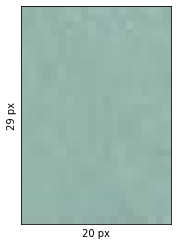

{'x': 92, 'y': 0, 'h': 29, 'w': 20}


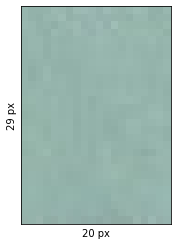

{'x': 94, 'y': 0, 'h': 29, 'w': 20}


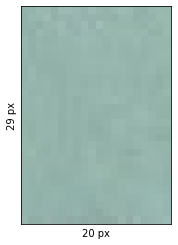

{'x': 96, 'y': 0, 'h': 29, 'w': 20}


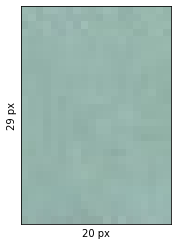

{'x': 98, 'y': 0, 'h': 29, 'w': 20}


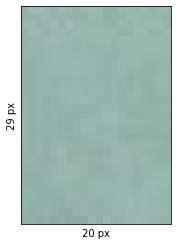

{'x': 100, 'y': 0, 'h': 29, 'w': 20}


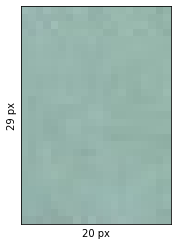

{'x': 102, 'y': 0, 'h': 29, 'w': 20}


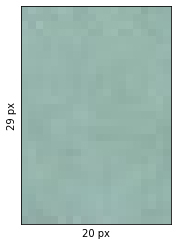

{'x': 104, 'y': 0, 'h': 29, 'w': 20}


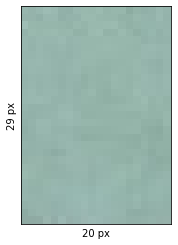

{'x': 106, 'y': 0, 'h': 29, 'w': 20}


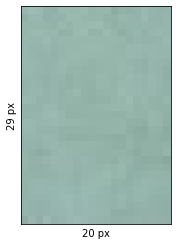

{'x': 108, 'y': 0, 'h': 29, 'w': 20}


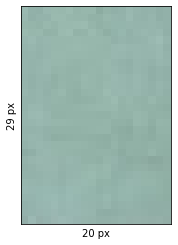

{'x': 110, 'y': 0, 'h': 29, 'w': 20}


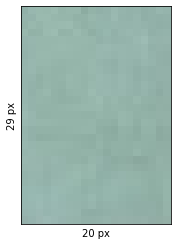

{'x': 112, 'y': 0, 'h': 29, 'w': 20}


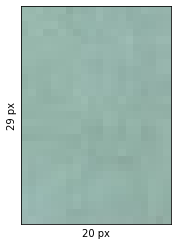

{'x': 114, 'y': 0, 'h': 29, 'w': 20}


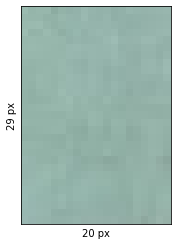

{'x': 116, 'y': 0, 'h': 29, 'w': 20}


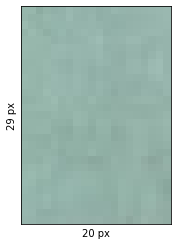

{'x': 118, 'y': 0, 'h': 29, 'w': 20}


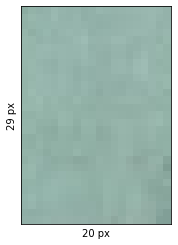

{'x': 120, 'y': 0, 'h': 29, 'w': 20}


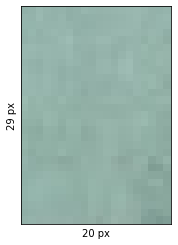

In [159]:
def sliding_window(image, step, ws):
    toret = []
    # We want to take into account all the height of the image, so we only need to move in the x axis
    y = 0
    for x in range(0, image.shape[1] - ws, step):
        toret.append({ "x": x, "y": 0, "h": image.shape[0], "w": ws })
        #toret.append({x, 0, image[0, x:x + ws[0]]))
    return toret

sliding_windows = sliding_window(pyramids[0], 2, 20)
for window in sliding_windows:
    print(window)
    x = window["x"]
    y = window["y"]
    h = window["h"]
    w = window["w"]
    show_image(pyramids[0][y:y+h, x:x+w])
    

### Step 3b: Take the sliding windows and pass it through our CNN originally trained for image classification

In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
# Load trained model on EMNIST dataset
MODEL_PATH = "/home/jsv/Documents/ForestProject/models/EMNIST-CNN-v3-bymerge"
model = tf.keras.models.load_model(MODEL_PATH, compile=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2769408   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 47)                6063      
Total params: 2,841,455
Trainable params: 2,841,455
Non-trainable params: 0
______________________________________________

In [100]:
# Preprocess image
def preprocess(image):
    bw_img = bw(image)
    gauss_img = gauss_blur(bw_img)
    roi_img = roi(bw_img, gauss_img)

    h, w = roi_img.shape
    if h <= 1 or w <= 1:
        bw_img = bw(image, 150)
        gauss_img = gauss_blur(bw_img)
        roi_img = roi(bw_img, gauss_img)
        
    result = pad_resize(roi_img)
    
    return result

In [101]:
class_mappings = {0: 48, 1: 49, 2: 50, 3: 51, 4: 52, 5: 53, 6: 54, 7: 55, 8: 56, 9: 57, 10: 65, 11: 66, 12: 67, 13: 68, 14: 69, 15: 70, 16: 71, 17: 72, 18: 73, 19: 74, 20: 75, 21: 76, 22: 77, 23: 78, 24: 79, 25: 80, 26: 81, 27: 82, 28: 83, 29: 84, 30: 85, 31: 86, 32: 87, 33: 88, 34: 89, 35: 90, 36: 97, 37: 98, 38: 100, 39: 101, 40: 102, 41: 103, 42: 104, 43: 110, 44: 113, 45: 114, 46: 116}


item = 19
x = sliding_windows[item]["x"]
y = sliding_windows[item]["y"]
h = sliding_windows[item]["h"]
w = sliding_windows[item]["w"]
img = pyramids[0][y:y+h, x:x+w]
prep_img = preprocess(img)
show_image(prep_img)

# Inference
prep_img = prep_img / 255
prep_img = prep_img.T


#sample = np.array([prep_img])
#sample.shape = (1, 28, 28, 1)
sample = prep_img.reshape(1, 28, 28, 1)
predictions = model.predict(sample)
print(predictions)

NameError: name 'sliding_windows' is not defined

In [17]:
classes = np.argmax(predictions, axis = 1)
for c in classes:
    c_name = chr(class_mappings[c])
    prob = predictions[0][c]
    print(f"It is a {c_name}: {prob}")

It is a t: 0.8937342166900635


### Main Loop

In [12]:
# slide a window across the image
def sliding_window(image, step, ws):
    #for y in range(0, image.shape[0] - ws[1], step):
    for x in range(0, image.shape[1] - ws[1], step):
        # yield the current window
        yield (x, 0, image[0:ws[0], x:x + ws[1]])
            
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        r = w / float(image.shape[1])
        dim = (w, int(image.shape[0] * r))
        image = cv2.resize(image, dsize=dim, interpolation=cv2.INTER_AREA)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[0] or image.shape[1] < minSize[1]:
            break
        # yield the next image in the pyramid
        yield image

In [13]:
show = False
rois = {}
for name_field, field in fields.items():
    rois_imgs = [] # holds ROI generated by the sliding window
    locs = [] # holds (x,y,w,h) coords where those ROI were found in respect with the original image
    W = field.shape[1]
    pyramid = image_pyramid(field, scale=2, minSize=(10, 70)) # inits the image pyramid

    for image in pyramid:
        # determine the scale factor between the *original* image
        # dimensions and the *current* layer of the pyramid
        scale = W / float(image.shape[1])
        # for each layer of the image pyramid, loop over the sliding
        # window locations
        window_size = (image.shape[0], 20)
        
        for (x, y, roiOrig) in sliding_window(image, step=3, ws=window_size):
            # scale the (x, y)-coordinates of the ROI with respect to the
            # *original* image dimensions
            x = int(x * scale)
            y = int(y * scale)
            w = int(window_size[1] * scale)
            h = int(window_size[0] * scale)
            # preprocess ROI  
            roi_prep = preprocess(roiOrig)
            # Normalize and reshape
            roi_prep = roi_prep/255
            roi_prep = roi_prep.T
            roi_prep.shape = (28, 28, 1)
            # update our list of ROIs and associated coordinates
            rois_imgs.append(roi_prep)
            locs.append((x, y, w, h))
            
            if show:
                # clone the original image and then draw a bounding box
                # surrounding the current region
                clone = field.copy()
                cv2.rectangle(clone, (x, y), (x + w, y + h),
                    (0, 255, 0), 1)
                # show the visualization and current ROI
                show_image(clone, "Visualization")
                show_image(roiOrig, "ROI")
    rois[name_field] = {"data": rois_imgs, "locs": locs}
    
    break

In [62]:
class_mappings = {0: 48, 1: 49, 2: 50, 3: 51, 4: 52, 5: 53, 6: 54, 7: 55, 8: 56, 9: 57, 10: 65, 11: 66, 12: 67, 13: 68, 14: 69, 15: 70, 16: 71, 17: 72, 18: 73, 19: 74, 20: 75, 21: 76, 22: 77, 23: 78, 24: 79, 25: 80, 26: 81, 27: 82, 28: 83, 29: 84, 30: 85, 31: 86, 32: 87, 33: 88, 34: 89, 35: 90, 36: 97, 37: 98, 38: 100, 39: 101, 40: 102, 41: 103, 42: 104, 43: 110, 44: 113, 45: 114, 46: 116}
labels = {}
for roi_imgs in rois.values():
    samples = np.array(roi_imgs['data'])
    locs = roi_imgs['locs']
    
    predictions = model.predict(samples)
    
    for i, preds in enumerate(predictions):
        max_idx = np.argmax(preds)
        cls = class_mappings[max_idx]
        prob = preds[max_idx]
        
        if prob > .95:
            L = labels.get(cls, [])
            L.append((locs[i], prob))
            labels[cls] = L
labels

{69: [((3, 0, 20, 29), 0.9659611), ((6, 0, 20, 29), 0.987163)],
 50: [((21, 0, 20, 29), 0.9999926)],
 84: [((42, 0, 20, 29), 0.99971586)],
 73: [((45, 0, 20, 29), 0.9606272)],
 51: [((63, 0, 20, 29), 0.9816506), ((72, 0, 20, 29), 0.9745885)],
 87: [((105, 0, 20, 29), 0.9556237)],
 77: [((96, 0, 40, 28), 0.9873285)]}

In [63]:
# Non maxima supression
# https://github.com/jrosebr1/imutils/blob/c12f15391fcc945d0d644b85194b8c044a392e0a/imutils/object_detection.py
# https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

Bounding boxes for class: 69 (E)


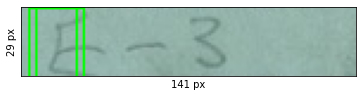

Now with NMS


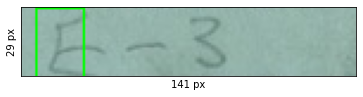

Bounding boxes for class: 50 (2)


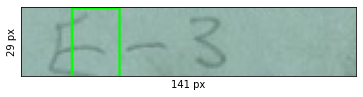

Now with NMS


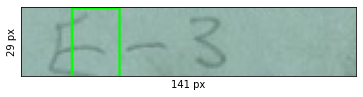

Bounding boxes for class: 84 (T)


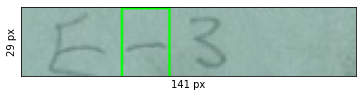

Now with NMS


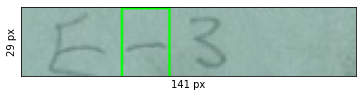

Bounding boxes for class: 73 (I)


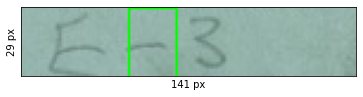

Now with NMS


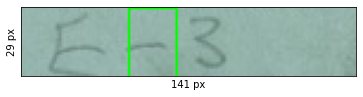

Bounding boxes for class: 51 (3)


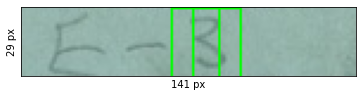

Now with NMS


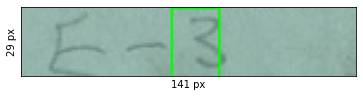

Bounding boxes for class: 87 (W)


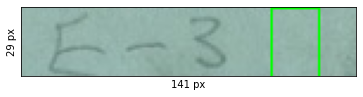

Now with NMS


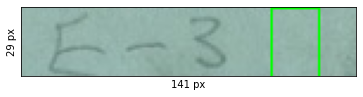

Bounding boxes for class: 77 (M)


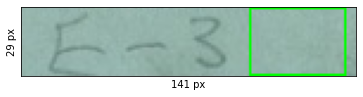

Now with NMS


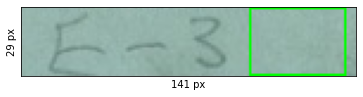

In [64]:
field = fields.get('WRITEUP NO.')
for label, boxes in labels.items():
    cls = chr(int(label))
    print(f"Bounding boxes for class: {label} ({cls})")
    tmp = field.copy()
    
    for box in boxes:
        cv2.rectangle(tmp, (box[0][0], box[0][1]), (box[0][0] + box[0][2], box[0][1] + box[0][3]), (0, 255, 0), 1)
    
    show_image(tmp)
    
    print("Now with NMS")
    
    tmp = field.copy()
    boxes = np.array([p[0] for p in labels[label]])
    probs = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, probs)
    
    for box in boxes:
        cv2.rectangle(tmp, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 255, 0), 1)
    show_image(tmp)
    

# Cleaned Version

#### Imports

In [115]:
import os
import json

import cv2
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

#### Preprocessing function definitions

In [116]:
def preprocess(image):
    bw_img = bw(image)
    gauss_img = gauss_blur(bw_img)
    roi_img = roi(bw_img, gauss_img)
    
    h, w = roi_img.shape
    if h <= 1 or w <= 1:
        bw_img = bw(image, 150)
        gauss_img = gauss_blur(bw_img)
        
        
    result = pad_resize(roi_img)
    
    return result

def bw(image, threshold=None, show=False):
    # First transform the image to gray scale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Sometimes we choose to set the threshold manually assuming that the Otsu algorithm wasn't unable to find a proper one
    if threshold:
        (thresh, bw_img) = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY_INV)
    else:
        # Treshold set to -0 to point out that it's Otsu's algorithm job to decide it
        (thresh, bw_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    if show:
        show_image(gray_img, "Gray scale")
        show_image(bw_img, "Trehshold (B&W)")
    
    return bw_img

def gauss_blur(image, show=False):
    
    gauss_img = cv2.GaussianBlur(
        src=image,
        ksize=(3,3),
        sigmaX=.5)
    
    if show: show_image(gauss_img, "Gaussian Blur")
    
    return gauss_img

def roi(bw_img, gauss_img, rect_thresh=3, show=False):

    ctrs, hier = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    if len(rects) > 0:
        if len(rects) == 1: # Only one contour found
            x, y, w, h = rects[0]
        else:
            # This approach coalesces rectangles in a way that we end up with the outmost ROI
            x, y, w, h = (None, None, None, None)
            for r in rects:
                # Unpack elements
                x1, y1, w1, h1 = r
                # If the width or height of the rectangle passes a threshold value
                if w1 >= rect_thresh and h1 >= rect_thresh:
                    if x != None and y != None and w != None and h != None:
                        # We have to take that x or y that is closer to the origin
                        if x1 < x:
                            x_tmp = x1
                        else:
                            x_tmp = x
                        if y1 < y:
                            y_tmp = y1
                        else:
                            y_tmp = y
                        # We have to compute the new width and height with respect of the outer x and y
                        if x1 + w1 > x + w:
                            w_tmp = (x1 + w1) - x_tmp
                        else:
                            w_tmp = (x + w) - x_tmp
                        if y1 + h1 > y + h:
                            h_tmp = (y1 + h1) - y_tmp
                        else:
                            h_tmp = (y + h) - y_tmp
                        # Update the outmost ROI
                        x, y, w, h = x_tmp, y_tmp, w_tmp, h_tmp
                    else:
                        x, y, w, h = r
            # We didn't find a proper rectangle. Assing the one with smallest width or height so we assure that 
            # the thresholding algorithm will run again with a manual value
            if x == None and y == None and w == None and h == None:
                x, y, w, h = rects[0]
                for r in rects[1:]:
                    x1, y1, w1, h1 = r
                    if w1 < w or h1 < h:
                        x, y, w, h = r

        roi = gauss_img[y:y+h, x:x+w]

        if show: show_image(roi, "ROI")
    else:
        return None
    
    return roi

def pad_resize(roi_img, show=False):    
    # Extracted ROI centered in a square frame with lengths equal to the largest dimension
    h, w = roi_img.shape
    l_dim = max(h, w)
    bg_img = np.zeros((l_dim, l_dim)).astype('uint8')
    
    # Compute xoff and yoff for placement of upper left corner of resized image
    yoff = round((l_dim-h)/2)
    xoff = round((l_dim-w)/2)

    cent_img = bg_img.copy()
    cent_img[yoff:yoff+h, xoff:xoff+w] = roi_img
    if show: show_image(cent_img, "Centered")

    # Square frame padded with two empty pixels
    pad_img = cv2.copyMakeBorder(cent_img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
    if show: show_image(pad_img, "Padded")

    # Downscale or upscale https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/
    #res_img = cv2.resize(src=pad_img, dsize=(28,28), fx=1, fy=1, interpolation=cv2.INTER_CUBIC)
    res_img = cv2.resize(src=pad_img, dsize=(28,28), interpolation=cv2.INTER_CUBIC)
    if show: show_image(res_img, "Resized Image")
    
    return res_img

#### Object detection function definitions

In [132]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        r = w / float(image.shape[1])
        dim = (w, int(image.shape[0] * r))
        image = cv2.resize(image, dsize=dim, interpolation=cv2.INTER_AREA)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[0] or image.shape[1] < minSize[1]:
            break
        # yield the next image in the pyramid
        yield image
        
# slide a window across the image
def sliding_window(image, step, ws):
    #for y in range(0, image.shape[0] - ws[1], step):
    for x in range(0, image.shape[1] - ws[1], step):
        # yield the current window
        yield (x, 0, image[0:ws[0], x:x + ws[1]])
        
# Non Maxima Supression
# https://github.com/jrosebr1/imutils/blob/c12f15391fcc945d0d644b85194b8c044a392e0a/imutils/object_detection.py
# https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

#### Loop

In [118]:
def grab_fields_coords():
    with open(FIELDS_FILENAME, "r") as f:
        content = json.loads(f.read())

    return content

def grab_fields():
    toret = {}
    fields = grab_fields_coords()['fields']
    form = cv2.imread(FORM_FILENAME)
    for field in fields:
        name = field['field']
        x = field['coord_pixel'][0]
        y = field['coord_pixel'][1]
        w = field['width']
        h = field['height']
    
        form_field = form[y:y+h, x:x+w]
        toret[name] = form_field
    
    return toret

Field: WRITEUP NO.
Bounding boxes for class: 69 (E)


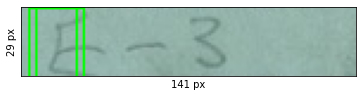

Now with NMS


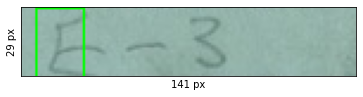

Bounding boxes for class: 50 (2)


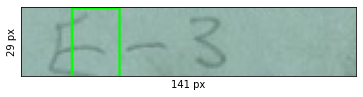

Now with NMS


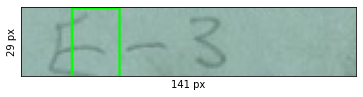

Bounding boxes for class: 84 (T)


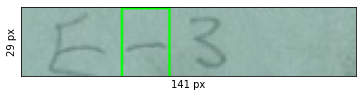

Now with NMS


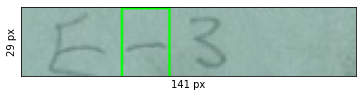

Bounding boxes for class: 73 (I)


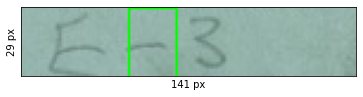

Now with NMS


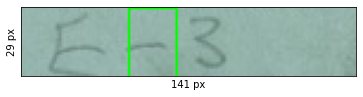

Bounding boxes for class: 51 (3)


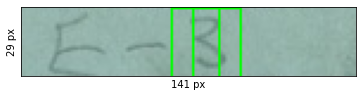

Now with NMS


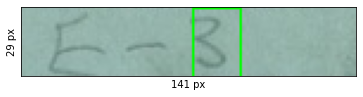

Bounding boxes for class: 87 (W)


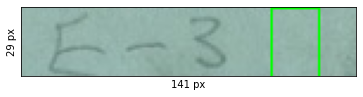

Now with NMS


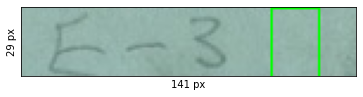

Bounding boxes for class: 77 (M)


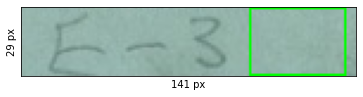

Now with NMS


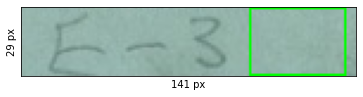

Field: PHOTO NO.
Bounding boxes for class: 50 (2)


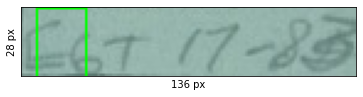

Now with NMS


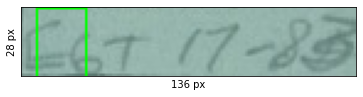

Bounding boxes for class: 54 (6)


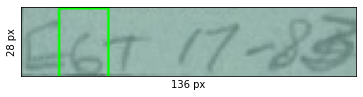

Now with NMS


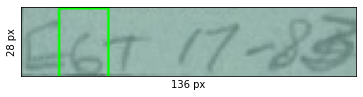

Bounding boxes for class: 84 (T)


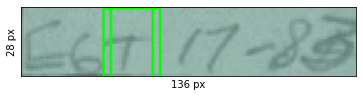

Now with NMS


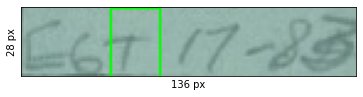

Bounding boxes for class: 55 (7)


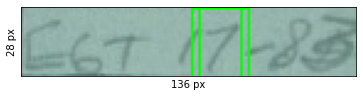

Now with NMS


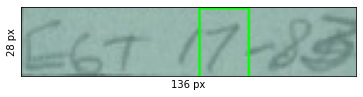

Field: FOREST
Bounding boxes for class: 83 (S)


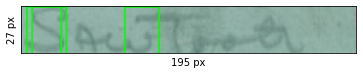

Now with NMS


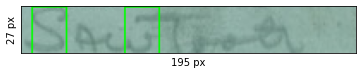

Bounding boxes for class: 75 (K)


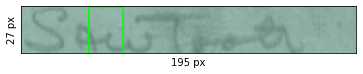

Now with NMS


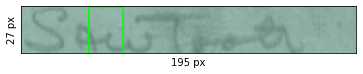

Bounding boxes for class: 85 (U)


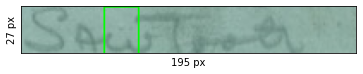

Now with NMS


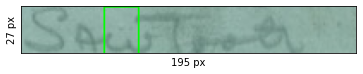

Bounding boxes for class: 55 (7)


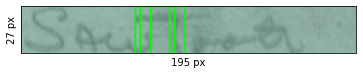

Now with NMS


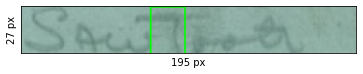

Bounding boxes for class: 54 (6)


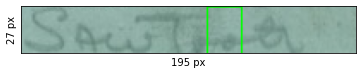

Now with NMS


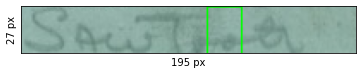

Bounding boxes for class: 77 (M)


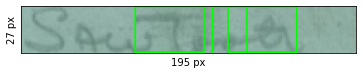

Now with NMS


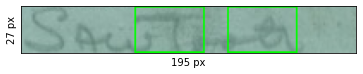

Bounding boxes for class: 87 (W)


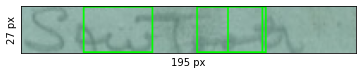

Now with NMS


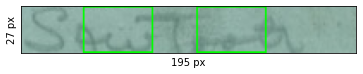

Bounding boxes for class: 76 (L)


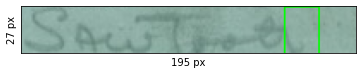

Now with NMS


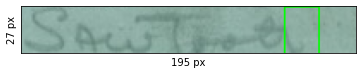

Bounding boxes for class: 97 (a)


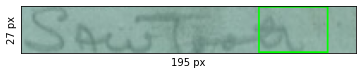

Now with NMS


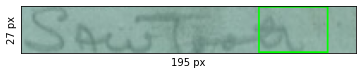

Field: RANGER DISTRICT
Bounding boxes for class: 116 (t)


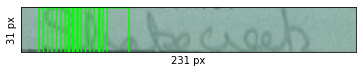

Now with NMS


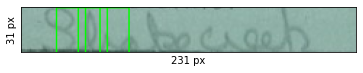

Bounding boxes for class: 97 (a)


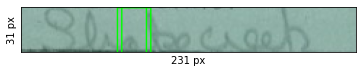

Now with NMS


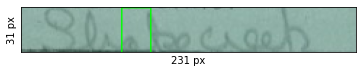

Bounding boxes for class: 98 (b)


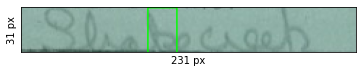

Now with NMS


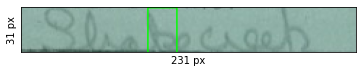

Bounding boxes for class: 85 (U)


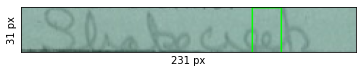

Now with NMS


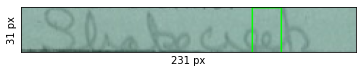

Bounding boxes for class: 50 (2)


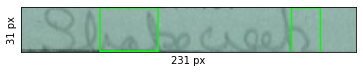

Now with NMS


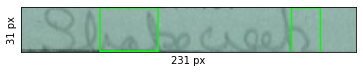

Bounding boxes for class: 76 (L)


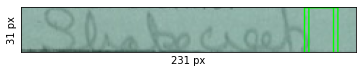

Now with NMS


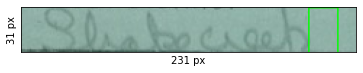

Bounding boxes for class: 87 (W)


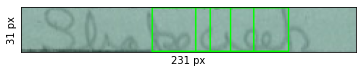

Now with NMS


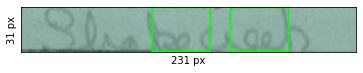

Bounding boxes for class: 104 (h)


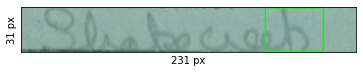

Now with NMS


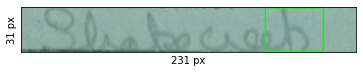

Field: ALLOTMENT
Bounding boxes for class: 85 (U)


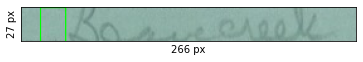

Now with NMS


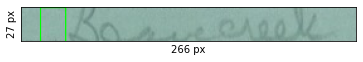

Bounding boxes for class: 87 (W)


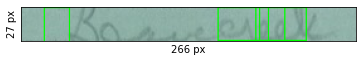

Now with NMS


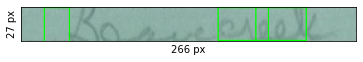

Bounding boxes for class: 100 (d)


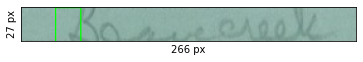

Now with NMS


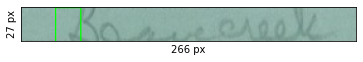

Bounding boxes for class: 66 (B)


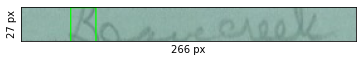

Now with NMS


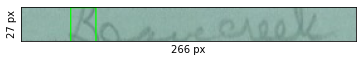

Bounding boxes for class: 97 (a)


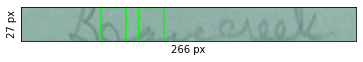

Now with NMS


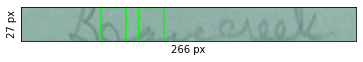

Bounding boxes for class: 50 (2)


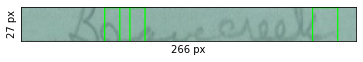

Now with NMS


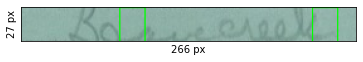

Bounding boxes for class: 76 (L)


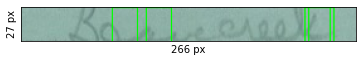

Now with NMS


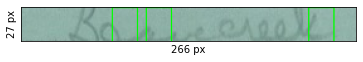

Field: EXAMINER
Bounding boxes for class: 87 (W)


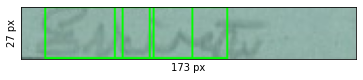

Now with NMS


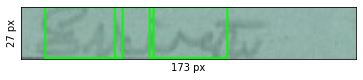

Bounding boxes for class: 50 (2)


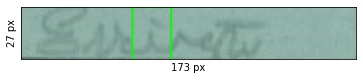

Now with NMS


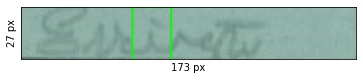

Bounding boxes for class: 77 (M)


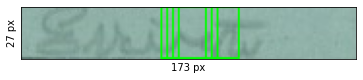

Now with NMS


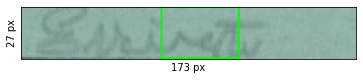

Field: DATE
Bounding boxes for class: 53 (5)


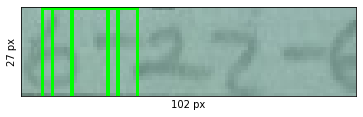

Now with NMS


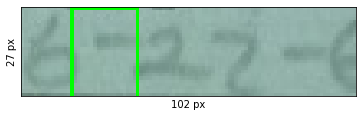

Bounding boxes for class: 50 (2)


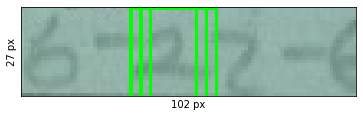

Now with NMS


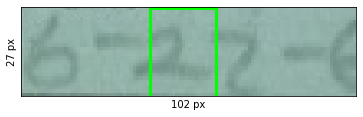

Field: TRANSECT NO.
Bounding boxes for class: 77 (M)


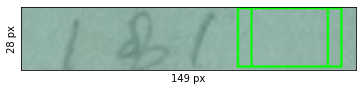

Now with NMS


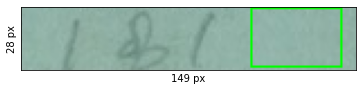

Field: PLOT SIZE
Bounding boxes for class: 57 (9)


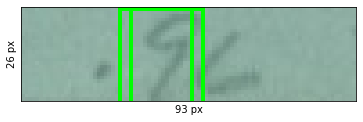

Now with NMS


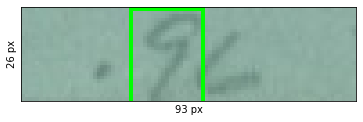

Bounding boxes for class: 54 (6)


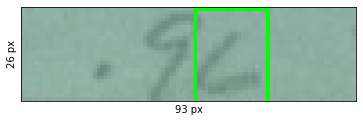

Now with NMS


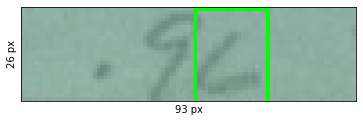

Bounding boxes for class: 50 (2)


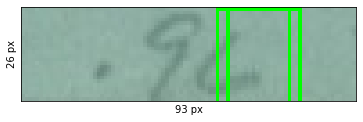

Now with NMS


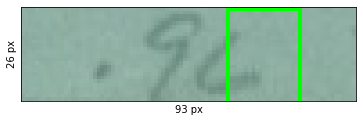

Field: PLOT INTERVAL
Bounding boxes for class: 116 (t)


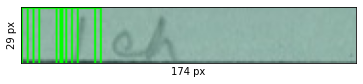

Now with NMS


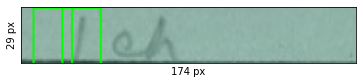

Bounding boxes for class: 75 (K)


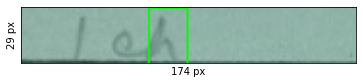

Now with NMS


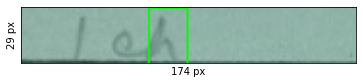

Bounding boxes for class: 85 (U)


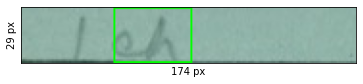

Now with NMS


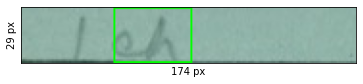

Field: TYPE DESIGNATION
Bounding boxes for class: 83 (S)


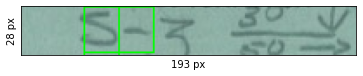

Now with NMS


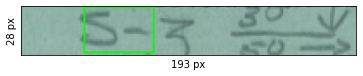

Bounding boxes for class: 114 (r)


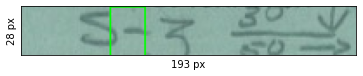

Now with NMS


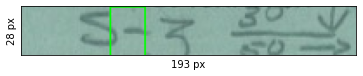

Bounding boxes for class: 51 (3)


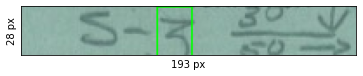

Now with NMS


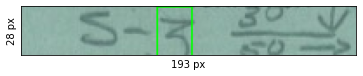

Bounding boxes for class: 50 (2)


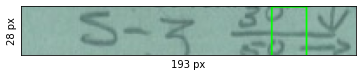

Now with NMS


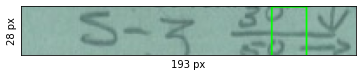

Field: KIND OF LIVESTOCK
Bounding boxes for class: 83 (S)


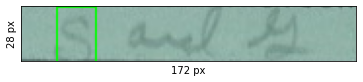

Now with NMS


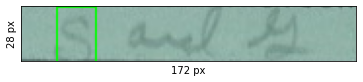

Bounding boxes for class: 97 (a)


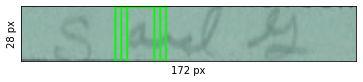

Now with NMS


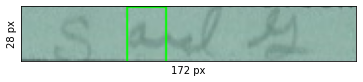

Bounding boxes for class: 85 (U)


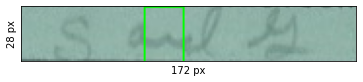

Now with NMS


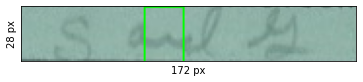

Bounding boxes for class: 77 (M)


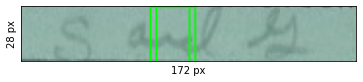

Now with NMS


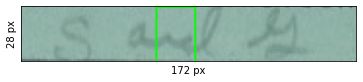

Bounding boxes for class: 87 (W)


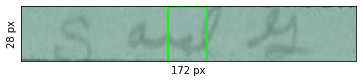

Now with NMS


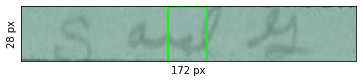

Bounding boxes for class: 100 (d)


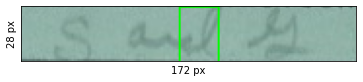

Now with NMS


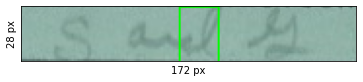

Field: SLOPE
Bounding boxes for class: 53 (5)


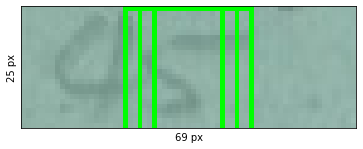

Now with NMS


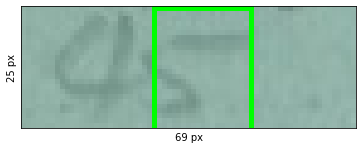

Bounding boxes for class: 74 (J)


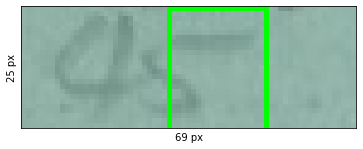

Now with NMS


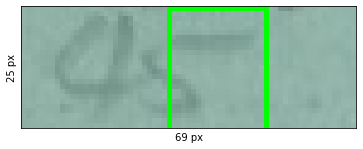

Bounding boxes for class: 84 (T)


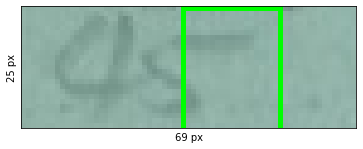

Now with NMS


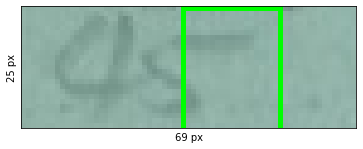

Field: ASPECT
Bounding boxes for class: 85 (U)


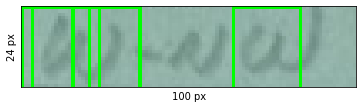

Now with NMS


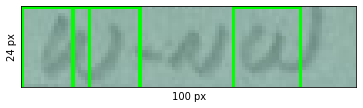

Bounding boxes for class: 78 (N)


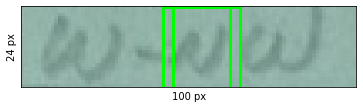

Now with NMS


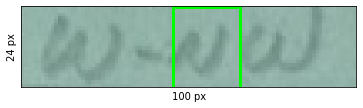

Bounding boxes for class: 87 (W)


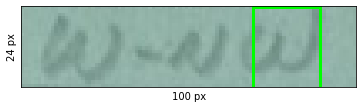

Now with NMS


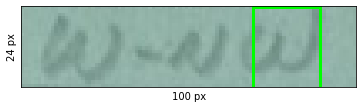

Field: LOCATION
Bounding boxes for class: 116 (t)


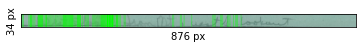

Now with NMS


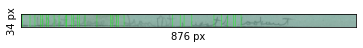

Bounding boxes for class: 87 (W)


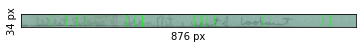

Now with NMS


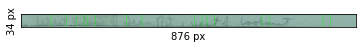

Bounding boxes for class: 54 (6)


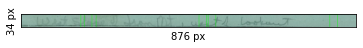

Now with NMS


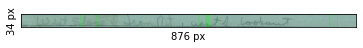

Bounding boxes for class: 77 (M)


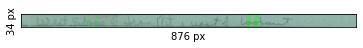

Now with NMS


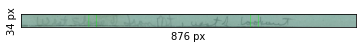

Bounding boxes for class: 50 (2)


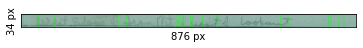

Now with NMS


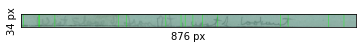

Bounding boxes for class: 68 (D)


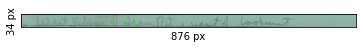

Now with NMS


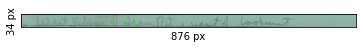

Bounding boxes for class: 76 (L)


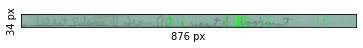

Now with NMS


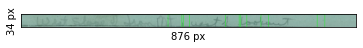

Bounding boxes for class: 85 (U)


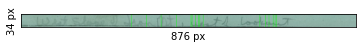

Now with NMS


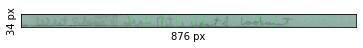

Bounding boxes for class: 100 (d)


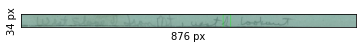

Now with NMS


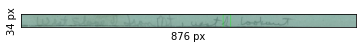

Bounding boxes for class: 52 (4)


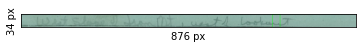

Now with NMS


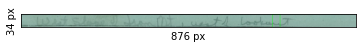

Field: ELEVATION
Bounding boxes for class: 55 (7)


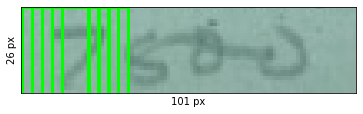

Now with NMS


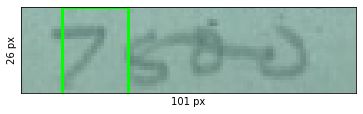

Bounding boxes for class: 77 (M)


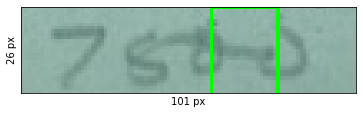

Now with NMS


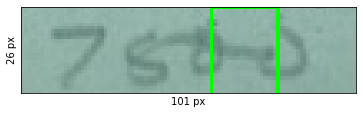

In [162]:

DATA_FOLDER = "data"
OUTPUT_FOLDER = "output"
FIELDS_FILENAME = "all_fields.json"
FORM_FILENAME = "highRes_ForestService.jpg"

CLASS_MAPPINGS = {0: 48, 1: 49, 2: 50, 3: 51, 4: 52, 5: 53, 6: 54, 7: 55, 8: 56, 9: 57, 10: 65, 11: 66, 12: 67, 13: 68, 14: 69, 15: 70, 16: 71, 17: 72, 18: 73, 19: 74, 20: 75, 21: 76, 22: 77, 23: 78, 24: 79, 25: 80, 26: 81, 27: 82, 28: 83, 29: 84, 30: 85, 31: 86, 32: 87, 33: 88, 34: 89, 35: 90, 36: 97, 37: 98, 38: 100, 39: 101, 40: 102, 41: 103, 42: 104, 43: 110, 44: 113, 45: 114, 46: 116}

rois = {} # Holds the pre-processed windows of all pyramids for each field along with its scaled coordinates
labels = {} # Holds for each field the classes found by the CNN along with its positions and probabilities

fields = grab_fields()

# Grabs the field image, get its image pyramids and run through all them a window slice. Then, preprocess those
# window slices and store them.
for name_field, field in fields.items():
    rois_imgs = [] # holds ROI generated by the sliding window
    locs = [] # holds (x,y,w,h) coords where those ROI were found in respect with the original image7

    W = field.shape[1]
    pyramid = image_pyramid(field, scale=2, minSize=(10, 70)) # inits the image pyramid

    for image in pyramid:
        # determine the scale factor between the *original* image
        # dimensions and the *current* layer of the pyramid
        scale = W / float(image.shape[1])
        # for each layer of the image pyramid, loop over the sliding
        # window locations
        window_size = (image.shape[0], 20)
        
        for (x, y, roiOrig) in sliding_window(image, step=3, ws=window_size):
            # scale the (x, y)-coordinates of the ROI with respect to the
            # *original* image dimensions
            x = int(x * scale)
            y = int(y * scale)
            w = int(window_size[1] * scale)
            h = int(window_size[0] * scale)
            # preprocess ROI  
            roi_prep = preprocess(roiOrig)
            # Normalize and reshape
            roi_prep = roi_prep/255
            roi_prep = roi_prep.T
            roi_prep.shape = (28, 28, 1)
            # update our list of ROIs and associated coordinates
            rois_imgs.append(roi_prep)
            locs.append((x, y, w, h))
            
            if show:
                # clone the original image and then draw a bounding box
                # surrounding the current region
                clone = field.copy()
                cv2.rectangle(clone, (x, y), (x + w, y + h),
                    (0, 255, 0), 1)
                # show the visualization and current ROI
                show_image(clone, "Visualization")
                show_image(roiOrig, "ROI")
    rois[name_field] = {"data": rois_imgs, "locs": locs}
    
# Pass each fields window slices through the CNN and classify them. Store those that meet certain criteria
# along with its scaled coordinates.
for name_field in rois.keys():
    roi_imgs = rois[name_field]
    samples = np.array(roi_imgs['data'])
    locs = roi_imgs['locs']

    predictions = model.predict(samples)

    for i, preds in enumerate(predictions):
        max_idx = np.argmax(preds)
        cls = class_mappings[max_idx]
        prob = preds[max_idx]

        if prob > .95:
            if not name_field in labels.keys():
                labels[name_field] = {}
            L = labels[name_field].get(cls, [])
            L.append((locs[i], prob))
            labels[name_field][cls] = L

# Perform NMS to take out overlapping bouding boxes
for field_name, field_labels in labels.items():
    print(f"Field: {field_name}")
    for label, boxes in field_labels.items():
        cls = chr(int(label))
        print(f"Bounding boxes for class: {label} ({cls})")
        tmp = fields[field_name].copy()
        for box in boxes:
            cv2.rectangle(tmp, (box[0][0], box[0][1]), (box[0][0] + box[0][2], box[0][1] + box[0][3]), (0, 255, 0), 1)

        show_image(tmp)

        print("Now with NMS")

        tmp = fields[field_name].copy()
        boxes = np.array([p[0] for p in boxes])
        probs = np.array([p[1] for p in boxes])
        boxes = non_max_suppression(boxes, probs)

        for box in boxes:
            cv2.rectangle(tmp, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 255, 0), 1)
        show_image(tmp)